In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-04-17 22:14:03.093545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [7]:
# For testing
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

2023-04-17 22:16:02.850780: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:16:02.899691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:16:02.900799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:16:02.902665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Test bert model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626286   0.99280983 -0.1861189   0.36673835  0.15233701  0.65504444
  0.9681153  -0.948627    0.00216158 -0.9877732   0.06842719 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946322  0.3432122   0.33231512 ...  0.2130085   0.7102077
  -0.05771145]
 [-0.28742045  0.31981018 -0.2301861  ...  0.58455044 -0.21329743
   0.7269206 ]
 [-0.6615702   0.68876827 -0.8743304  ...  0.10877316 -0.26173204
   0.47855455]
 ...
 [-0.22561158 -0.28925583 -0.07064367 ...  0.47566044  0.83277196
   0.40025324]
 [-0.298242   -0.27473158 -0.05450519 ...  0.48849782  1.0955359
   0.1816341 ]
 [-0.44378144  0.00930715  0.07223722 ...  0.17290151  1.1833243
   0.07898054]]


In [9]:
# Build a model
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [10]:
# Test model
classifier_model = build_classifier_model()
classifier_model.summary()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [14]:
# # Tensor example
# # Load a testing dataset
# url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

# dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
#                                   untar=True, cache_dir='.',
#                                   cache_subdir='')

# dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# train_dir = os.path.join(dataset_dir, 'train')

# # remove unused folders to make it easier to load the data
# remove_dir = os.path.join(train_dir, 'unsup')
# shutil.rmtree(remove_dir)

# AUTOTUNE = tf.data.AUTOTUNE
# batch_size = 32
# seed = 42

# raw_train_ds = tf.keras.utils.text_dataset_from_directory(
#     'aclImdb/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='training',
#     seed=seed)

# class_names = raw_train_ds.class_names
# train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# val_ds = tf.keras.utils.text_dataset_from_directory(
#     'aclImdb/train',
#     batch_size=batch_size,
#     validation_split=0.2,
#     subset='validation',
#     seed=seed)

# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# test_ds = tf.keras.utils.text_dataset_from_directory(
#     'aclImdb/test',
#     batch_size=batch_size)

# test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# # Look at some review
# for text_batch, label_batch in train_ds.take(1):
#   for i in range(3):
#     print(f'Review: {text_batch.numpy()[i]}')
#     label = label_batch.numpy()[i]
#     print(f'Label : {label} ({class_names[label]})')

84125825/84125825 [==============================] - 18s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br 

2023-04-06 11:20:29.050197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
# Load SMS data and prepare them for training

# Load the dataset
df = pd.read_csv('../dataset/set_01_02_new.csv', encoding='utf-8').dropna()
df.columns = ['label', 'text']

# Use sklearn to split the dataset into training, validating and testing
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=24)

# Create training dataset
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['text'].values, train_df['label'].values)
)
train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)
val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Create testing dataset
test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)
test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

# Look at some data
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'SMS: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label}')


SMS: b'fuuuuck need stop sleepin sup'
Label : 0
SMS: b'\xe4\xbb\x8a\xe6\x97\xa5 \xe7\x9c\x9f \xe4\xbf\x82 \xe4\xb8\x8d \xe5\x85\x94 \xe4\xb8\x8d\xe5\xbf\xab \xe7\xa5\x9d \xe4\xbd\xa0 \xe5\x85\x94\xe5\xb9\xb4 \xe9\x8c\xa2 \xe5\x85\x94 \xe7\x84\xa1\xe9\x99\x90 \xe5\xa4\xa7\xe5\xb1\x95 \xe9\xb4\xbb \xe5\x85\x94 \xe7\xa6\x8f\xe5\x85\x94 \xe7\xb6\xbf\xe5\xbb\xb6 \xe5\x85\x94\xe8\xba\x8d\xe6\x96\xb0\xe7\xa8\x8b \xe8\xb2\xa1\xe5\x88\xb0 \xe9\x81\x8b\xe5\x88\xb0 \xe7\xa6\x8f\xe5\x85\x94 \xe5\x88\xb0 \xe6\x81\xad\xe5\x96\x9c \xe6\x81\xad\xe5\x96\x9c \xe4\xb8\x8d\xe7\x9f\xa5 \xe4\xb8\x8d\xe8\xa6\xba \xe6\x88\x91 \xe5\x9c\xb0 instagram \xe9\x96\x8b \xe5\x92\x97 \xe5\x85\xa9\xe5\x80\x8b \xe6\x9c\x88 \xe5\x95\xa6 \xe5\xae\x9a\xe6\x9c\x9f \xe6\x9b\xb4\xe6\x96\xb0 \xe7\x82\xba \xe4\xbd\xa0 \xe6\x8f\x90\xe4\xbe\x9b \xe5\x8d\xb3\xe6\x99\x82 \xe6\x8b\x9b\xe8\x81\x98 \xe8\xa1\x8c\xe6\x83\x85 \xe6\x9c\x80\xe6\x96\xb0 \xe8\xa1\x8c\xe6\xa5\xad \xe8\xb6\xa8\xe5\x8b\xa2 \xe8\x81\xb7\xe5\xa0\xb4 \xe5\xb0\x8f \

2023-04-17 22:41:57.098860: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
# model fine tuning
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
print("steps_per_epoch ", steps_per_epoch)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

steps_per_epoch  130


In [14]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
130/130 [==============================] - 27s 154ms/step - loss: 0.2538 - binary_accuracy: 0.8861 - val_loss: 0.0816 - val_binary_accuracy: 0.9769
Epoch 2/5
130/130 [==============================] - 19s 150ms/step - loss: 0.0537 - binary_accuracy: 0.9841 - val_loss: 0.0623 - val_binary_accuracy: 0.9846
Epoch 3/5
130/130 [==============================] - 19s 148ms/step - loss: 0.0314 - binary_accuracy: 0.9894 - val_loss: 0.0573 - val_binary_accuracy: 0.9827
Epoch 4/5
130/130 [==============================] - 19s 150ms/step - loss: 0.0206 - binary_accuracy: 0.9945 - val_loss: 0.0599 - val_binary_accuracy: 0.9846
Epoch 5/5
130/130 [==============================] - 19s 149ms/step - loss: 0.0179 - binary_accuracy: 0.9940 - val_loss: 0.0610 - val_binary_accuracy: 0.9884


17/17 [==============================] - 2s 95ms/step - loss: 0.1134 - binary_accuracy: 0.9788
Loss: 0.11335528641939163
Accuracy: 0.9788461327552795
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


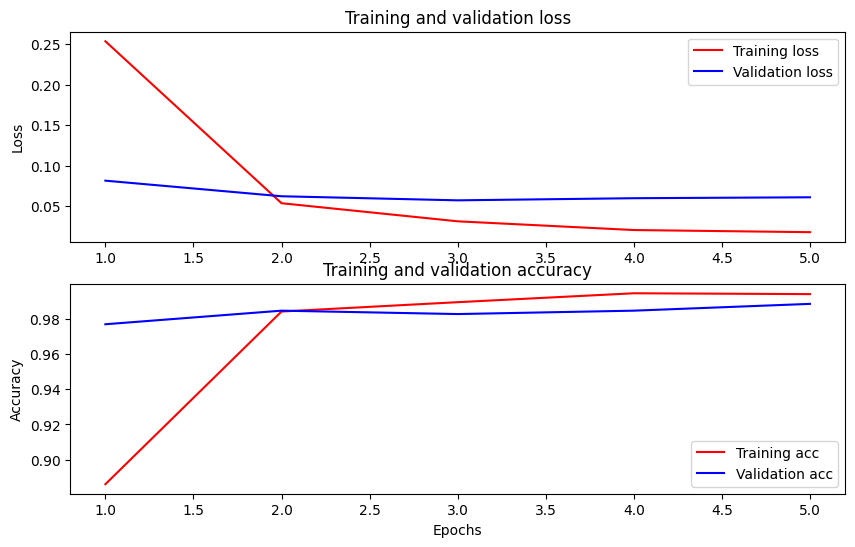

In [16]:
def evaluate_model(model, ds):
    # Evaluate performance
    loss, accuracy = model.evaluate(ds)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    
evaluate_model(classifier_model, test_ds)